# PCA from Scratch

```yaml
Course:   DS 5001
Module:   07 Homework
Topic:    PCA Homework
Author:   Andrew Avitabile
Date:     10 March 2024
```

# Set Up

## Import

In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import norm
from scipy.linalg import eigh
import plotly_express as px
import seaborn as sns

In [2]:
sns.set(style='ticks')

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home'] 
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'novels'

In [4]:
OHCO = ['book_id','chapter_id','para_num','sent_num','token_num']

In [5]:
# Added after class
norm_docs = True # This has the effect of exaggerating variance when False
center_term_vectors = True # This has the effect of demoting authorship when False

In [6]:
colors = "YlGnBu" 
# colors = "Spectral"

## Import tables

In [7]:
#1. Import the LIB and CORPUS tables from the provided CSV files.
LIB = pd.read_csv(f'{data_home}/{data_prefix}/{data_prefix}-LIB.csv').set_index('book_id')
CORPUS = pd.read_csv(f'{data_home}/{data_prefix}/{data_prefix}-CORPUS.csv')

# Extracting features

In [8]:
#2. Extract a VOCAB table and add max_pos as a feature.
VOCAB = CORPUS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = np.log2(1/VOCAB.p)
VOCAB['max_pos'] = CORPUS.reset_index().value_counts(['term_str','pos']).sort_index().unstack().idxmax(1)

In [9]:
#3. Compute TFIDF and VOCAB['dfidf'] for the CORPUS using the following parameters:
bag = ['book_id', 'chap_id']
tf_method = 'max'
idf_method = 'standard'

In [10]:
def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

In [11]:
def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack(fill_value=0) # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(1 + DTCM.T)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.astype('bool').sum()
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF

    return TFIDF

In [12]:
BOW = create_bow(CORPUS, bag=bag)

In [13]:
TFIDF = get_tfidf(BOW, tf_method=tf_method, df_method=idf_method)

In [14]:
#4. Create a DOC table from the TFIDF index in which each row represents a bag, i.e. a chapter. 
# In other words, it should have ['book_id', 'chap_id'] as its index. 
# This table should have information from the LIB table added to it, so that each chapter is identified with an author, title, and genre. 
# These data will appear in your visualizations. For example, in a scatter plot of documents in the first two principle components, you will want to know the book and chapter of each data point.

In [15]:
DTCM = BOW.n.unstack(fill_value=0)
DOC = DTCM.sum(1).to_frame('n_tokens')
DOC['n_types'] = DTCM.astype('bool').sum(1)
DOC['pkr'] = DOC.n_types / DOC.n_tokens
DOC = DOC.reset_index().set_index('book_id').join(LIB).reset_index()
DOC['label'] =  DOC['author_id'] + ', ' + DOC['book_id']
DOC['doc'] = DOC['book_id'] + ', ' + DOC['chap_id'].astype(str)
DOC = DOC.set_index(['book_id', 'chap_id']).loc[:, ['genre_id', 'author_id', 'label', 'doc']]
DOC

genre_id  author_id               label            doc
book_id    chap_id                                                       
adventures 1              d      doyle   doyle, adventures  adventures, 1
           2              d      doyle   doyle, adventures  adventures, 2
           3              d      doyle   doyle, adventures  adventures, 3
           4              d      doyle   doyle, adventures  adventures, 4
           5              d      doyle   doyle, adventures  adventures, 5
...                     ...        ...                 ...            ...
udolpho    54             g  radcliffe  radcliffe, udolpho    udolpho, 54
           55             g  radcliffe  radcliffe, udolpho    udolpho, 55
           56             g  radcliffe  radcliffe, udolpho    udolpho, 56
           57             g  radcliffe  radcliffe, udolpho    udolpho, 57
usher      1              g        poe          poe, usher       usher, 1

[320 rows x 4 columns]

In [16]:
#5. Create a reduced version of the TFIDF table with only the top 1000 nouns (i.e. NN and NNS) in descending order of DFIDF

In [17]:
DF = DTCM.astype('bool').sum() 
N = DTCM.shape[0]
print('IDF method:', idf_method)

if idf_method == 'standard':
    IDF = np.log2(N / DF)

elif idf_method == 'max':
    IDF = np.log2(DF.max() / DF) 

elif idf_method == 'smooth':
    IDF = np.log2((1 + N) / (1 + DF)) + 1

IDF method: standard


In [18]:
print('TF method:', tf_method)

if tf_method == 'sum':
    TF = DTCM.T / DTCM.T.sum()

elif tf_method == 'max':
    TF = DTCM.T / DTCM.T.max()
    
elif tf_method == 'log':
    TF = np.log2(1 + DTCM.T)
    
elif tf_method == 'raw':
    TF = DTCM.T
    
elif tf_method == 'double_norm':
    TF = DTCM.T / DTCM.T.max()
    
elif tf_method == 'binary':
    TF = DTCM.T.astype('bool').astype('int')
    
TF = TF.T

TF method: max


In [19]:
VOCAB['df'] = DF
VOCAB['idf'] = IDF
VOCAB['dfidf'] = VOCAB.df * VOCAB.idf

In [20]:
BOW['tf'] = TF.stack()
BOW['tfidf'] = TFIDF.stack()

In [21]:
TFIDF = BOW['tfidf'].unstack(fill_value=0)
VSHORT = VOCAB[VOCAB.max_pos.isin(['NN', 'NNS'])].sort_values('dfidf', ascending=False).head(1000)
TFIDF = TFIDF[VSHORT.index]

In [22]:
#TFIDF = TFIDF.join(DOC).reset_index().set_index(['book_id', 'chap_id', 'author_id', 'genre_id'])
#TFIDF

In [23]:
# 6. Write a function that computes PCA from a given document-term count matrix (this included weighted counts, such a tfidf). 
# It should return three dataframes: LOADINGS (the term-component matrix), DCM (the document-component matrix), COMPINF (the component information table). Give it the following parameters:

In [24]:
def compute_PCA(TFIDF, k, norm_docs=True, center_by_mean=True, center_by_variance=False):
    
    # Normalize doc vector lengths
    if norm_docs:
        TFIDF_L2 = (TFIDF.T / np.linalg.norm(TFIDF, 2, axis=1)).T

    # Remove bags with null
    a = len(TFIDF_L2)
    TFIDF_L2 = TFIDF_L2.dropna()
    b = len(TFIDF_L2)
    bag_loss = a - b
    print(f"Bag loss: {bag_loss}")

    # Center the term vectors
    if center_by_mean:
        TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()
    elif center_by_variance:
        TFIDF_L2 = TFIDF_L2 / TFIDF_L2.std()

    # Compute Covariance Matrix
    COV = TFIDF_L2.cov()

    # Decompose the Matrix
    eig_vals, eig_vecs = np.linalg.eigh(COV)

    # Convert eigen data to dataframes
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'

    # Combine eigenvalues and eigenvectors
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

    # Compute Explained Variance
    EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

    # Get components
    COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(k).reset_index(drop=True)
    COMPS.index.name = 'comp_id'
    COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
    COMPS.index.name = 'pc_id'
    
    # Extract Loadings (term-component matrix)
    loadings = COMPS.drop(['eig_val', 'exp_var'], axis=1).T
    
    # Compute Document-Component Matrix (DCM)
    DCM = TFIDF_L2 @ loadings
    DCM = DCM.join(DOC).reset_index().set_index(['book_id', 'chap_id'])

    # Component Information Table (COMPINF)
    comp_info = COMPS[['eig_val', 'exp_var']].rename(columns={'eig_val': 'Eigenvalue', 'exp_var': 'Explained Variance'})

    return loadings, DCM, comp_info

In [25]:
loadings, DCM, comp_info = compute_PCA(TFIDF = TFIDF, k = 10, norm_docs = True, center_by_mean = False, center_by_variance = False)

Bag loss: 0


In [26]:
#Vizualizations

In [27]:
def vis_pcs(M, a, b, label='author_id', hover_name='doc', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

In [28]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = loadings.join(VOCAB)
    return px.scatter(X.rename_axis('term_str').reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos', 
                      marginal_x='box', height=800)

# Questions

### 1. Looking at the documents plotted against the first principle component (PC), which genre has the more narrow range, i.e. distance between the minimum and maximum values? This can be seen using a box plot.

Detective novels have the narrower ranger

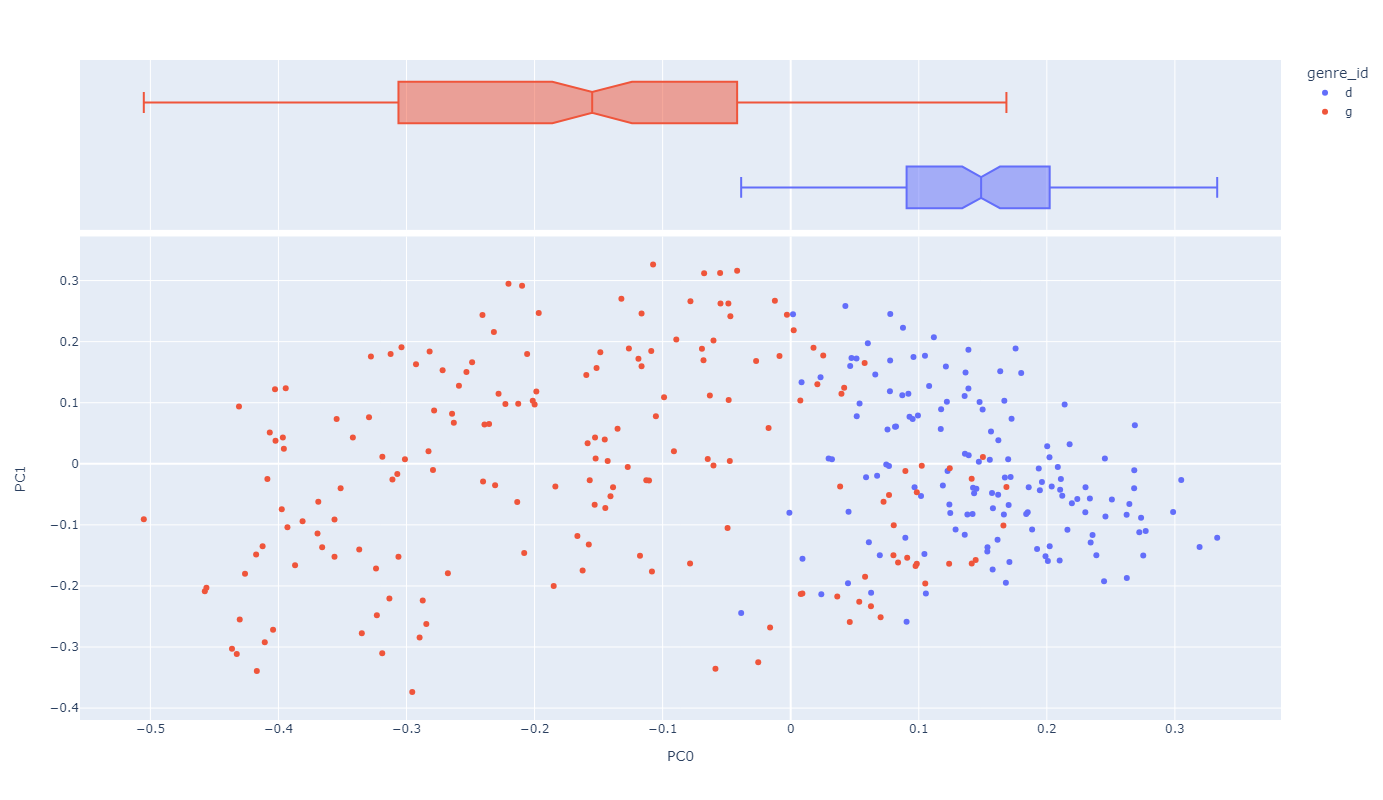

In [29]:
vis_pcs(DCM, 0, 1, label='genre_id')

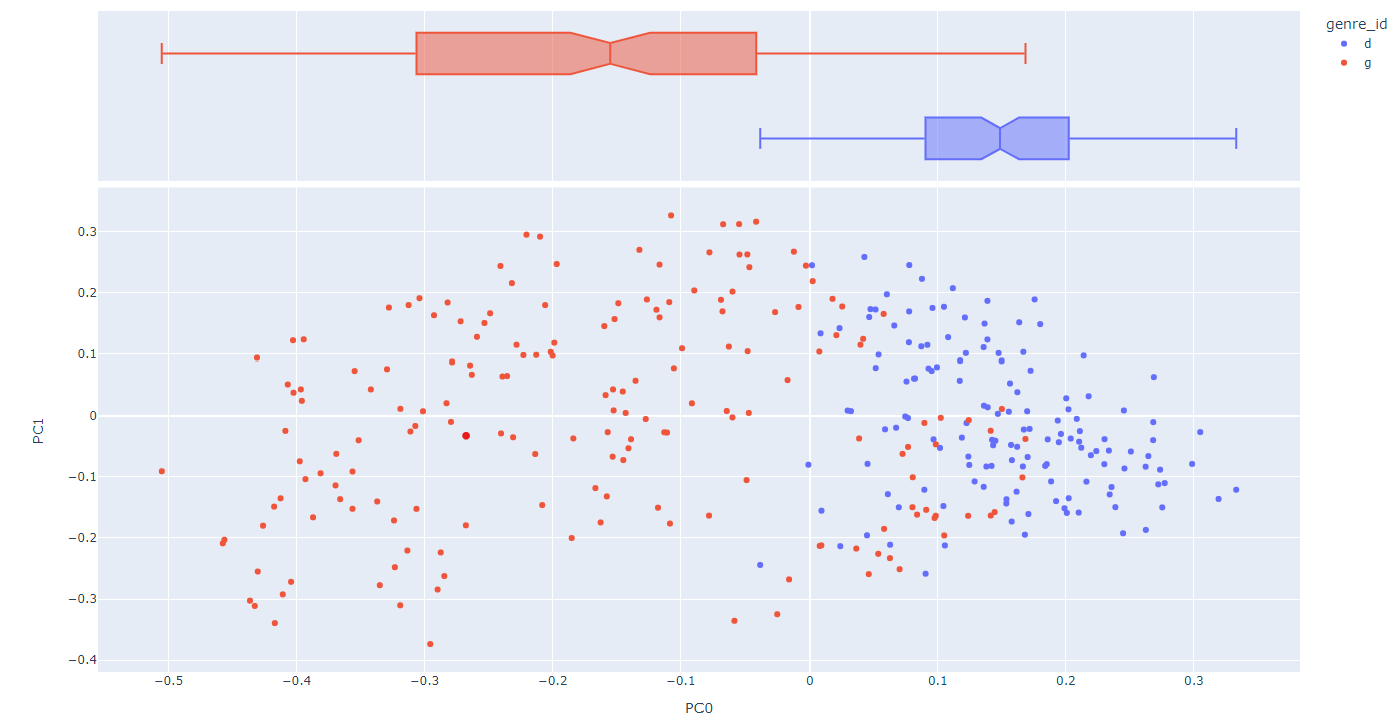

### 2. Looking at the documents plotted against the first PC, which author has the highest absolute value, in terms of both mean and range? In other words, which author is farthest from 0? Again, the box plots of each author are useful here.

Christie

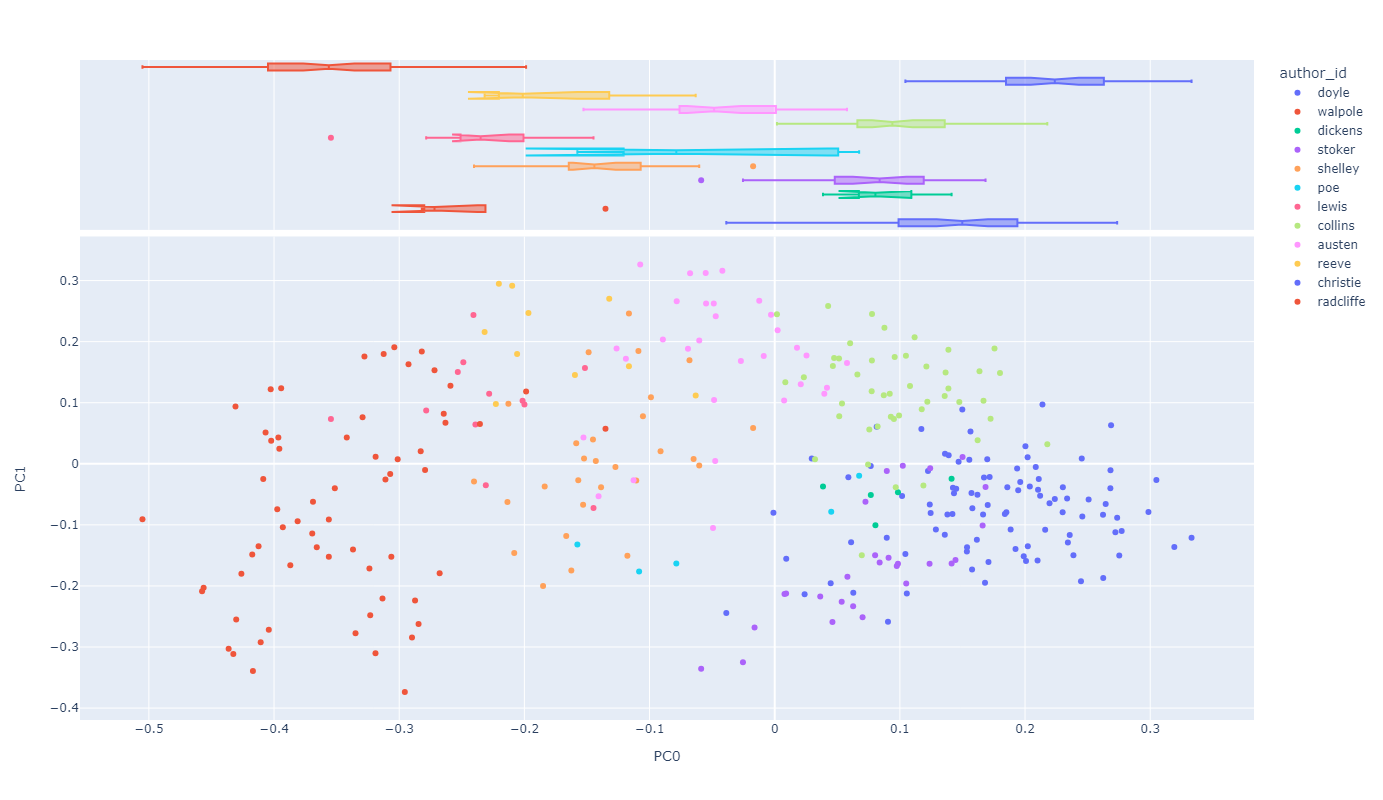

In [30]:
vis_pcs(DCM, 0, 1)

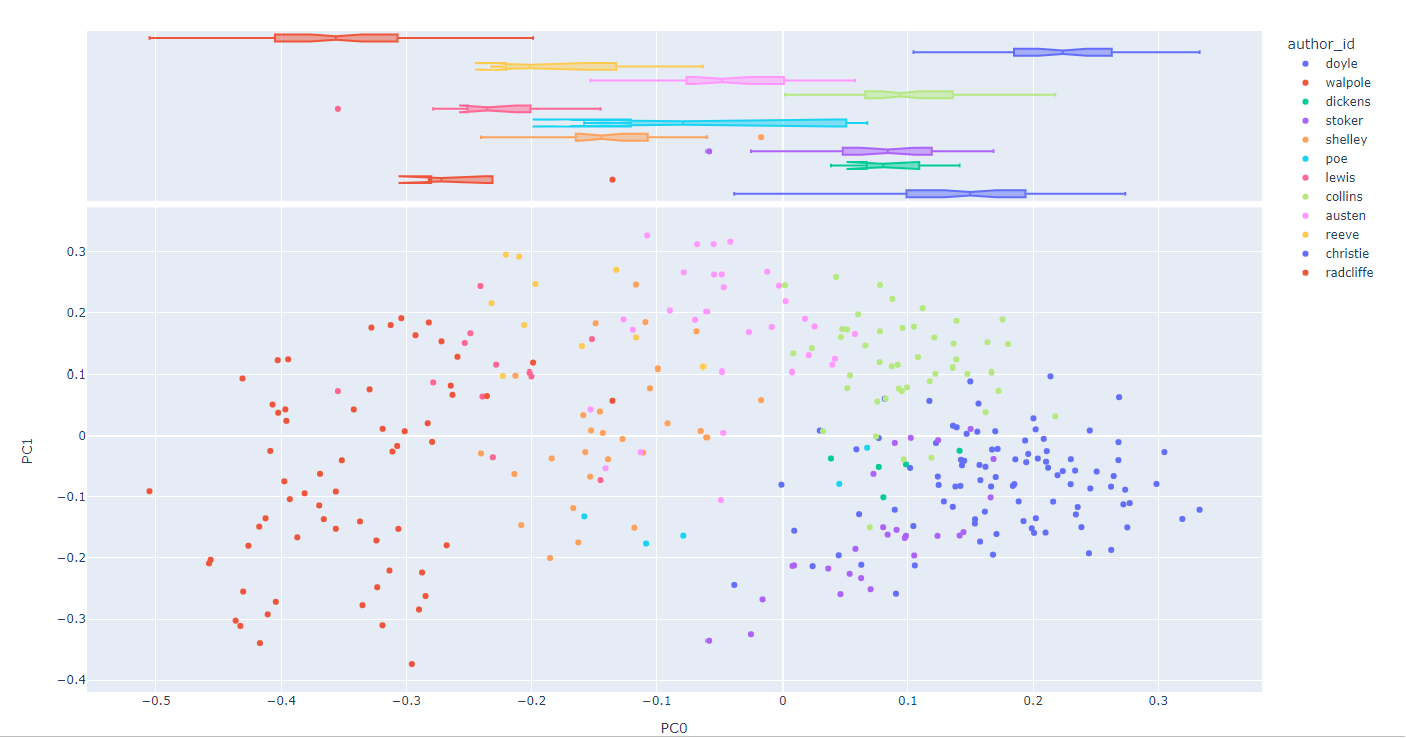

### 3. In the third PC, which author has, by far, the maximum range?

Wapole

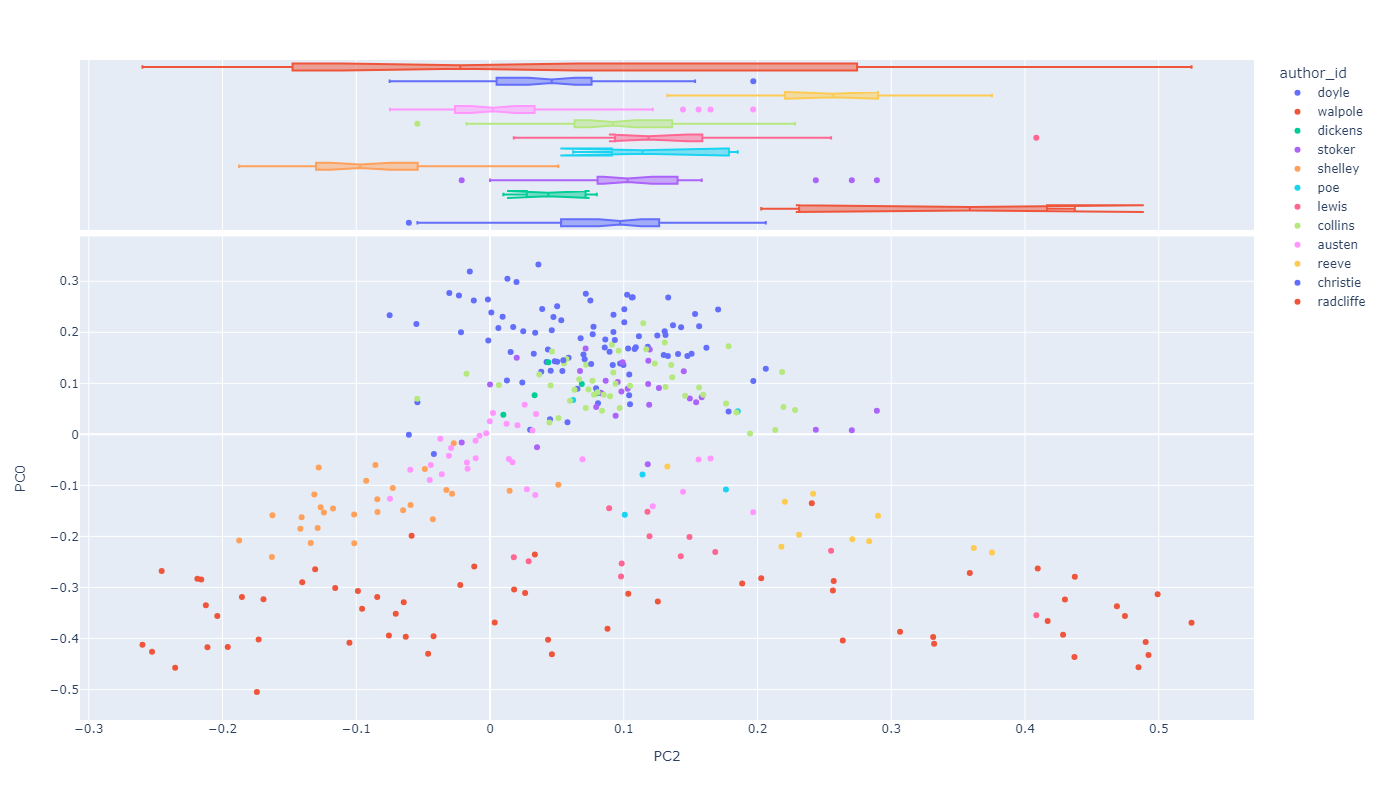

In [31]:
vis_pcs(DCM, 2, 0)

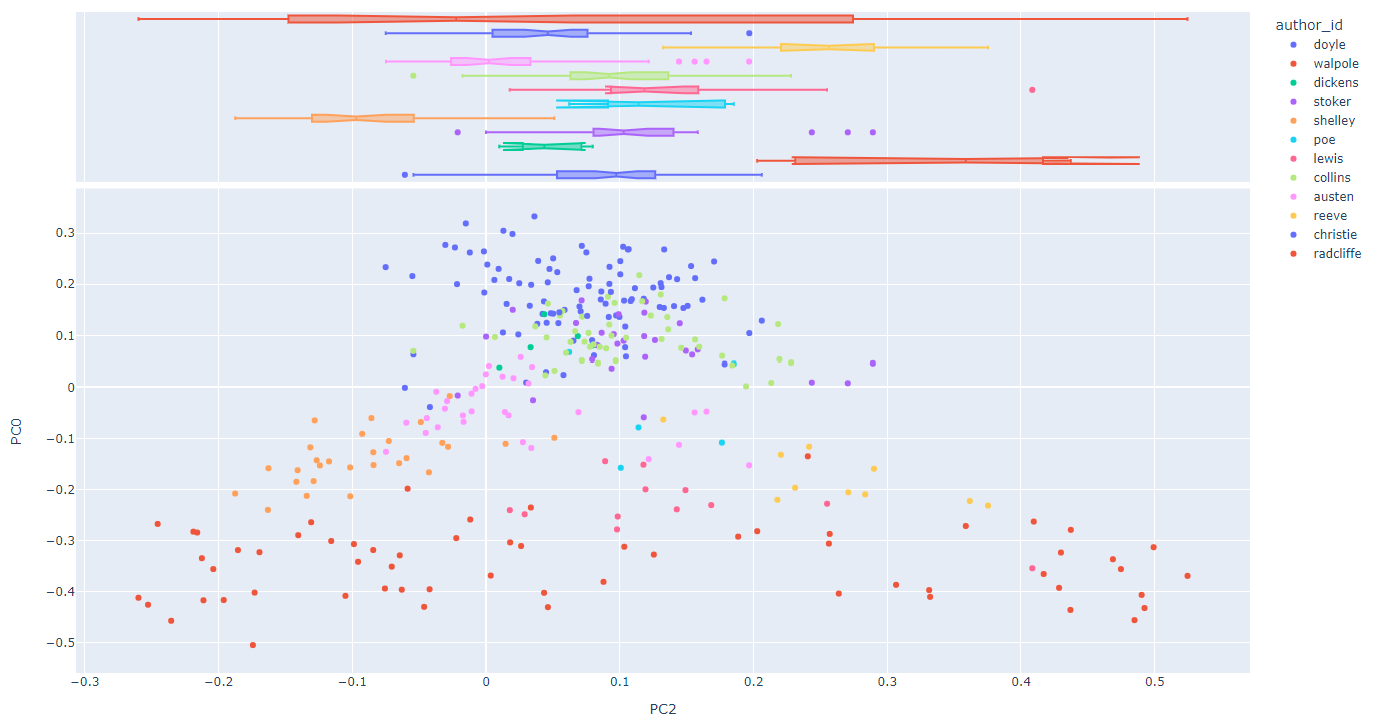

### 4. Looking at the loadings for the second PC, how would you characterize the opposition, based on the top three words at each pole?

The difference between NN and NNS is in the plurality of the words (i.e., NN = singular nouns and NNS = plural nouns)

NN: brother, engagement, father

NNS: ladies, feelings, terms

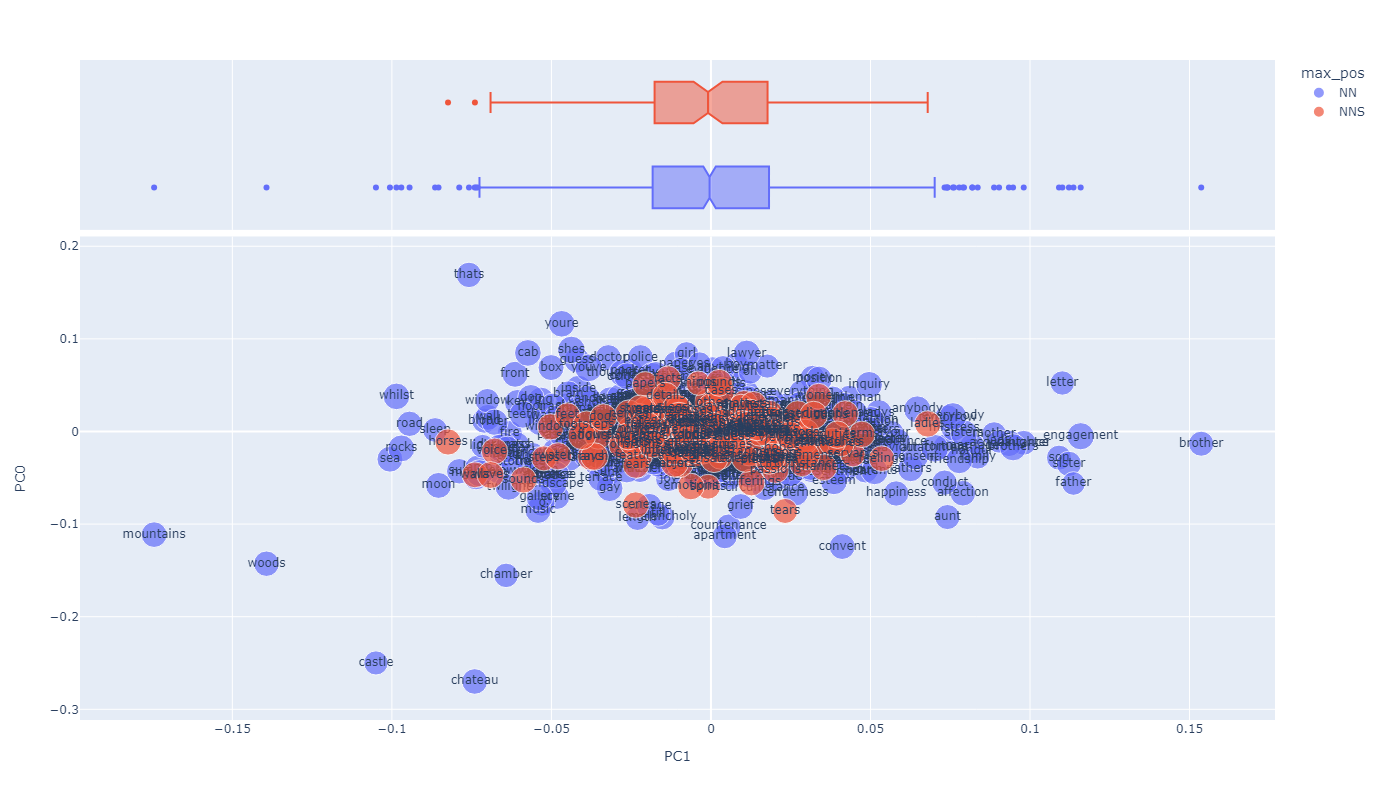

In [32]:
vis_loadings(1,0)

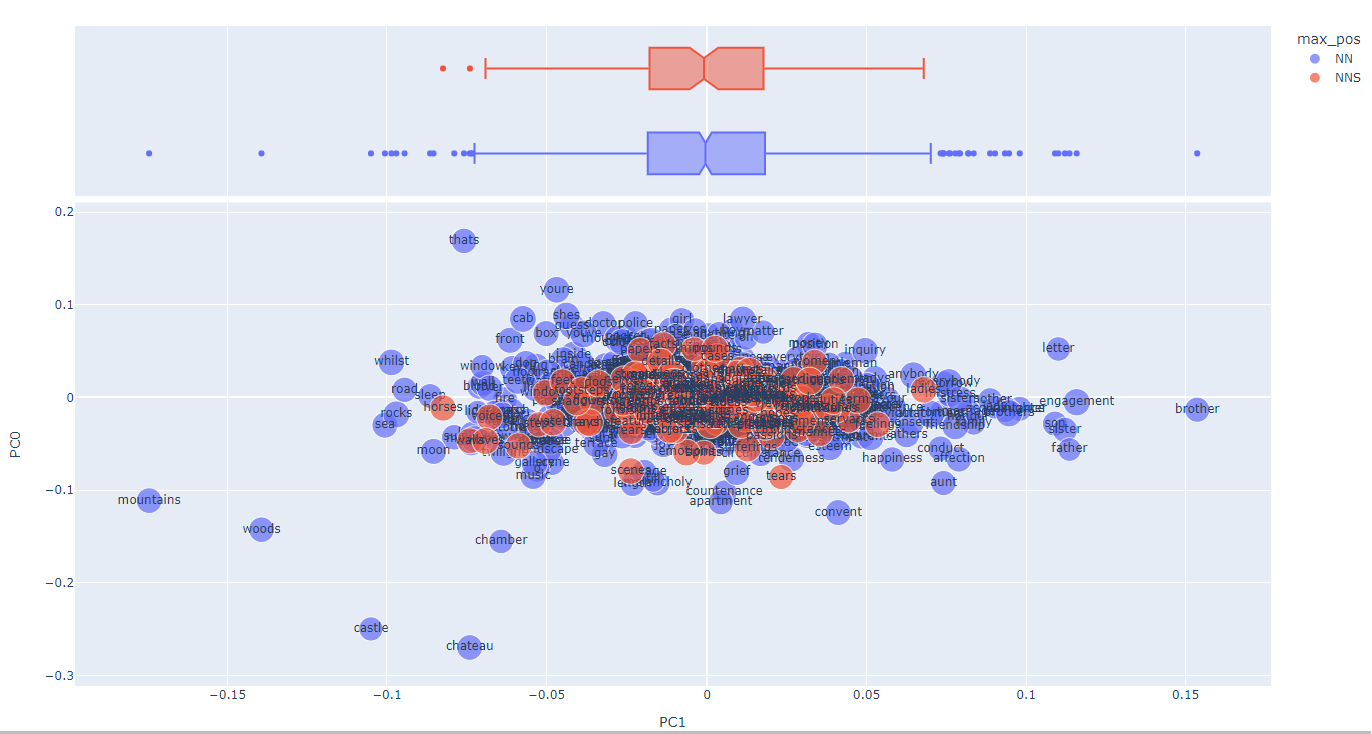

### 5. Recompute the principle components with center_by_variance set to True. This will change the words that appear at the extremes of the first PC. Does this change your interpretation in the previous question

No, I still think the difference is in the plurality.

NN: family, honour, conduct

NNS: ladies, circumstances, particulars

Bag loss: 0


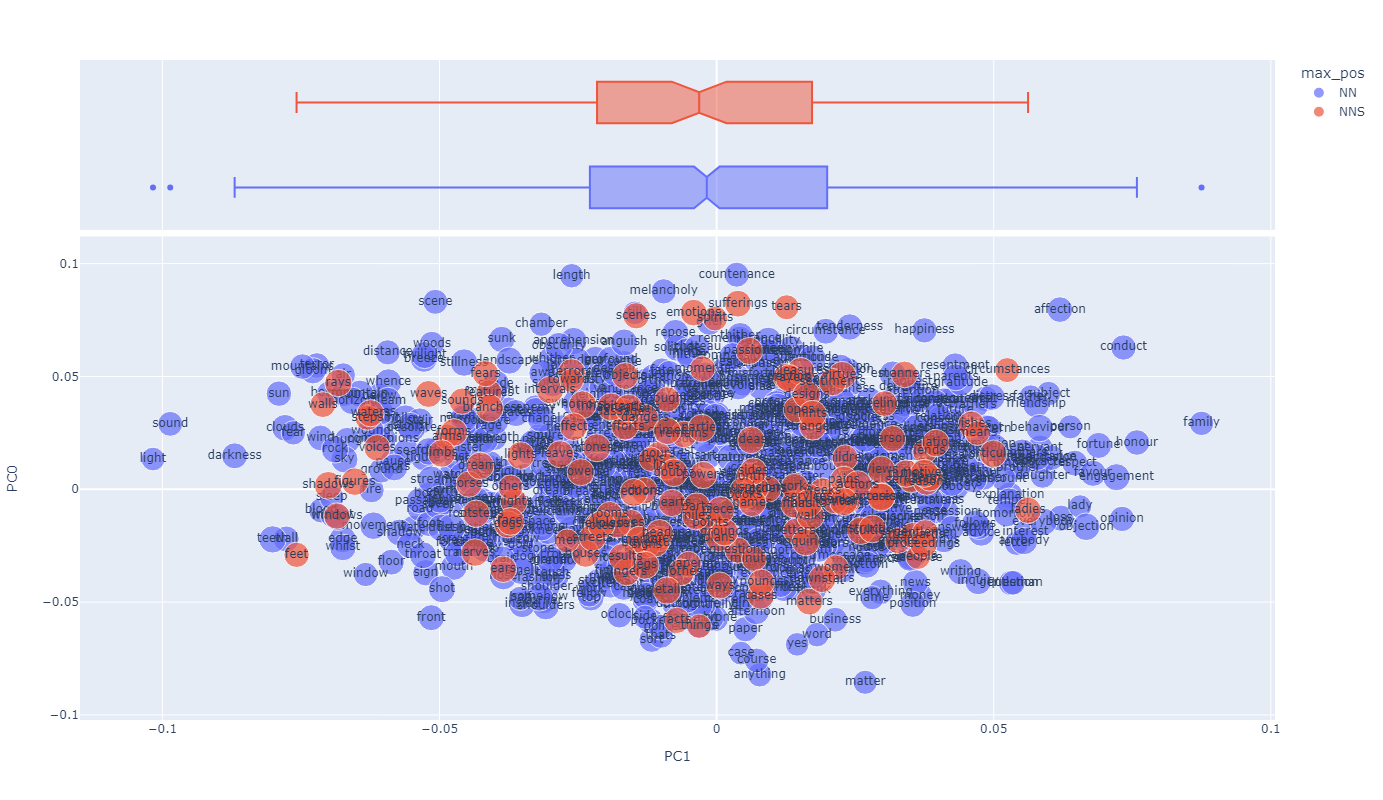

In [33]:
loadings, DCM, comp_info = compute_PCA(TFIDF = TFIDF, k = 10, norm_docs = True, center_by_mean = False, center_by_variance = True)
vis_loadings(1,0)

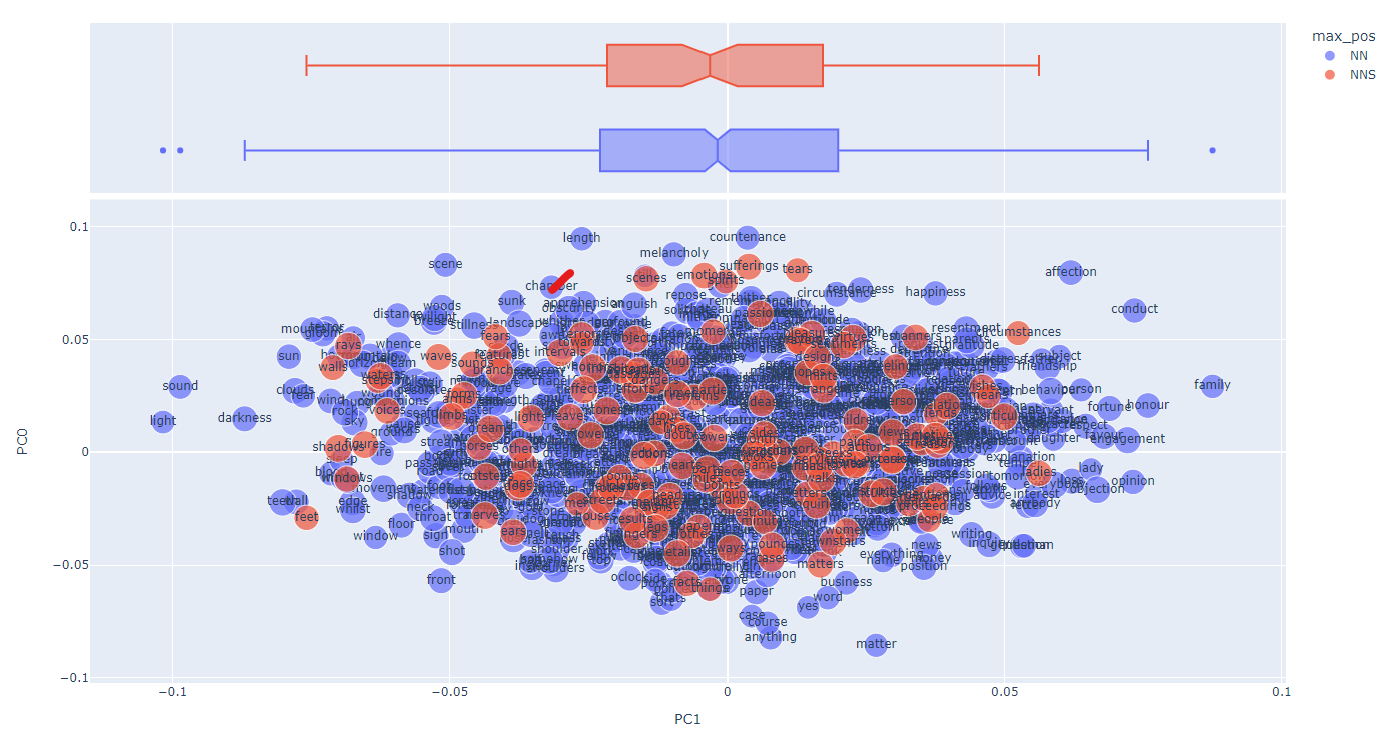